<a href="https://colab.research.google.com/github/npgeorge/DS-Unit-2-Applied-Modeling/blob/master/NHL_Data_Project_Game_Plays_Home_Goals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Answers

Choose your target. Which column in your tabular dataset will you predict?

I will predict on goals scored in home and away games for the Bruins. 

Is your problem regression or classification?

Regression, win or loss is binary. I could try classification as well. 

How is your target distributed?

Regression: Is the target right-skewed? If so, you may want to log transform the target. TBD. 


Choose which observations you will use to train, validate, and test your model.

    - Are some observations outliers? Will you exclude them? TBD
    - Will you do a random split or a time-based split? Random. 


Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Step 2
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2.1 Get the file
downloaded = drive.CreateFile({'id':'1QA0Xd4Uwp5-EbVpFE-02ceBCVnO17oKu'}) # replace the id with id of file you want to access
downloaded.GetContentFile('game_plays.csv')

In [0]:
df = pd.read_csv('game_plays.csv') 

In [6]:
df.head()

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side
0,2011030221_1,2011030221,1,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 18:16:06,0,0,Game Scheduled,NaN,NaN,NaN
1,2011030221_2,2011030221,2,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 19:19:49,0,0,Period Ready,NaN,NaN,NaN
2,2011030221_3,2011030221,3,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 19:20:13,0,0,Period Start,NaN,NaN,NaN
3,2011030221_4,2011030221,4,4.0,1.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200,2012-04-29 19:20:13,0,0,Sean Couturier faceoff won against Patrik Elias,0.0,0.0,right
4,2011030221_5,2011030221,5,4.0,1.0,Giveaway,NaN,28.0,24.0,1,REGULAR,21,1179,2012-04-29 19:21:02,0,0,Giveaway by Kimmo Timonen,-28.0,-24.0,right


In [7]:
df.shape #3.6 million rows!

(3632349, 20)

In [8]:
#bruins filter
bruins_id_condition = (df['team_id_for'] == 6) | (df['team_id_against'] == 6)
df_bruins = df[bruins_id_condition]
df_bruins.shape #ok so lets split the bruins in to train, val, and test

(216483, 20)

In [9]:
#baseline, can we beat the Bruins baseline target?
#lets see how accurately we can predict the goals they will score at away games. 
baseline_target = 'goals_away'
y_baseline = df_bruins[baseline_target]
y_baseline.value_counts(normalize=True) 

0    0.380325
1    0.288411
2    0.181608
3    0.093800
4    0.036174
5    0.014084
6    0.004615
7    0.000656
8    0.000254
9    0.000074
Name: goals_away, dtype: float64

In [10]:
baseline_target = 'goals_home'
y_baseline = df_bruins[baseline_target]
y_baseline.value_counts(normalize=True) 

0    0.361331
1    0.282484
2    0.179464
3    0.102359
4    0.044022
5    0.018935
6    0.007626
7    0.002698
8    0.000956
9    0.000125
Name: goals_home, dtype: float64

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
#train, test
train, test = train_test_split(df_bruins, 
                               train_size=0.80, 
                               test_size=0.20,
                               stratify=df_bruins['goals_home'], 
                               random_state=42)
train.shape, test.shape

((173186, 20), (43297, 20))

In [12]:
#train, val
train, val = train_test_split(train, 
                              train_size=0.80, 
                              test_size=0.20, 
                              stratify=train['goals_home'], 
                              random_state=42)
train.shape, val.shape

((138548, 20), (34638, 20))

In [0]:
#target and features
target = 'goals_home'
#drop target 
train_features = train.drop(columns=[target])
#numeric features
num_feat = train_features.select_dtypes(include='number').columns.tolist()
#Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
#Get a list of all categorical features with cardinality <= 60
cat_feat = cardinality[cardinality <= 60].index.tolist()
# Combine the lists 
features = num_feat + cat_feat

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [15]:
!pip install category_encoders

     |████████████████████████████████| 102kB 2.8MB/s 


In [16]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, 
                           n_jobs=-1, 
                           min_samples_leaf=1, 
                           max_depth=7, 
                           class_weight='balanced',
                           max_features=8, 
                           )
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on Train/Val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on Test Data
y_pred_rfc = pipeline.predict(X_test)

Training Accuracy 0.3954802667667523
Validation Accuracy 0.3862520930769675


In [17]:
from sklearn.metrics import accuracy_score
print('Test Accuracy for Random Forest', accuracy_score(y_test, y_pred_rfc))

Test Accuracy for Random Forest 0.38603136475968314


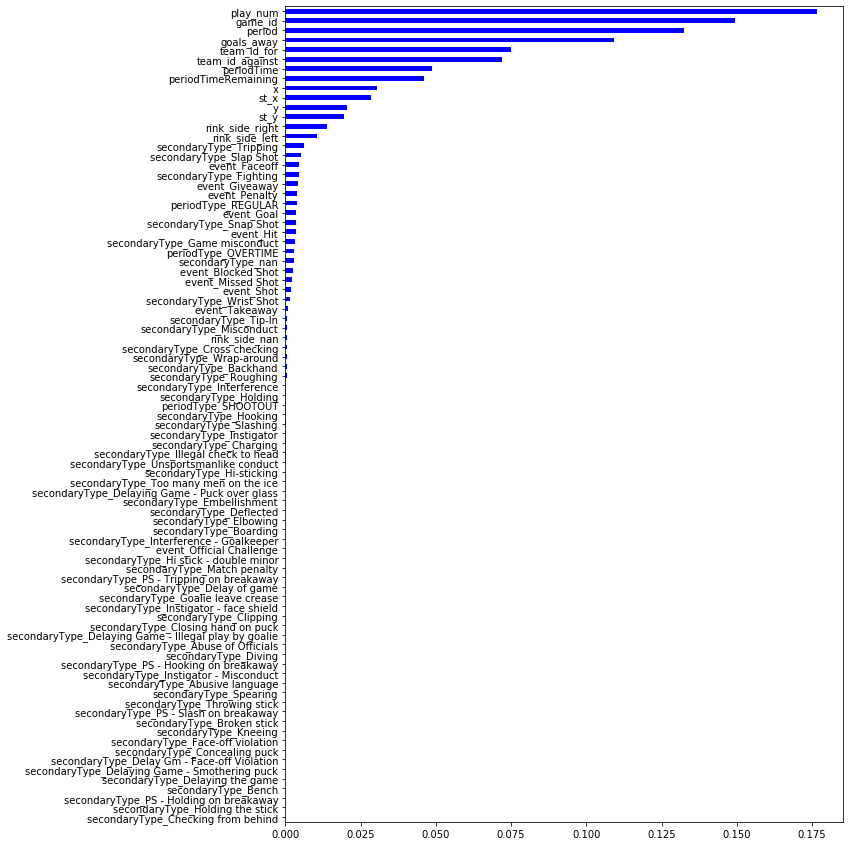

In [18]:
#feature importances
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,15))
importances.sort_values().plot.barh(color='blue');

In [21]:
#with XG Boost
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

#predict on test
y_pred_xgb = pipeline.predict(X_test)

Validation Accuracy: 0.49367746405681623


In [23]:
print('Test Accuracy for XG Boost', accuracy_score(y_test, y_pred_xgb))

Test Accuracy for XG Boost 0.4946763055177033


In [24]:
#permutation importance 
pipeline_pi = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = pipeline_pi.fit_transform(X_train)
X_val_transformed = pipeline_pi.transform(X_val)


model_pi = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_pi.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [25]:
!pip install eli5

     |████████████████████████████████| 112kB 2.9MB/s 


In [26]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model_pi,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [27]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.2753 ± 0.0029,game_id
0.2585 ± 0.0024,play_num
0.2383 ± 0.0028,goals_away
0.2010 ± 0.0025,period
0.1062 ± 0.0012,team_id_for
0.1051 ± 0.0023,team_id_against
0.0793 ± 0.0015,periodTimeRemaining
0.0634 ± 0.0019,periodTime
0.0208 ± 0.0016,rink_side
0.0047 ± 0.0010,periodType
